# Exploratory analysis : NLP FOMC Project

In [126]:
#!pip install wordcloud

In [1]:
import numpy as np
import pandas as pd
from urllib import request
import bs4
from wordcloud import WordCloud, STOPWORDS 
from tqdm.notebook import trange
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/h2jw/Documents/GitHub/NLP-FOMC/RA_project/final_df_v4.csv", low_memory=True)

In [3]:
#df  = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1','Unnamed: 0.1.1.1'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126782 entries, 0 to 126781
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         126782 non-null  int64  
 1   Unnamed: 0.1       126782 non-null  int64  
 2   Unnamed: 0.1.1     126782 non-null  int64  
 3   Unnamed: 0.1.1.1   126782 non-null  int64  
 4   Date               126782 non-null  object 
 5   interlocutor_name  126782 non-null  object 
 6   statement _size    126782 non-null  int64  
 7   statement          126725 non-null  object 
 8   statement_number   126782 non-null  object 
 9   chair_in_charge    126782 non-null  object 
 10  score_acadam       126782 non-null  float64
 11  score_hostile      126782 non-null  float64
 12  score_econo        126782 non-null  float64
 13  score_virtue       126782 non-null  float64
 14  score_vice         126782 non-null  float64
 15  score_hawkish      126782 non-null  float64
 16  sc

## Preprocessing

La base s'arrête en 2014, on va rajouter le scrapping de 2015 avec les codes contenus dans `codes scrapping`.

In [8]:
# add 2015 update

### Chairs

In [107]:
pd.unique(df.chair_in_charge)

array(['CHAIRMAN BURNS', 'CHAIRMAN MILLER', 'CHAIRMAN VOLCKER',
       'CHAIRMAN GREENSPAN', 'CHAIRMAN BERNANKE', 'CHAIR YELLEN'],
      dtype=object)

Text(0.5, 0, 'Chair person')

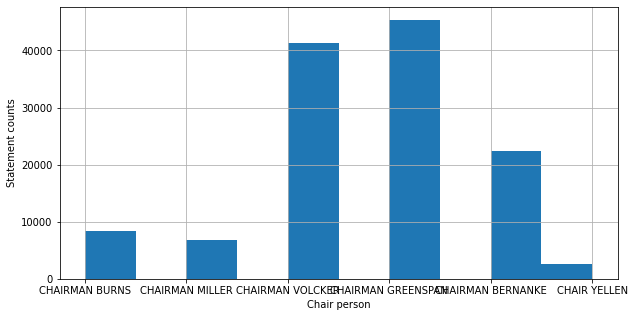

In [114]:
plt.figure(figsize=(10,5))
df['chair_in_charge'].hist()
plt.ylabel('Statement counts')
plt.xlabel('Chair person')

In [126]:
pd.unique(df['interlocutor_name'])

array(['CHAIRMAN BURNS', 'MR HOLMES', 'MR BLACK', 'MR PARDEE',
       'MR COLDWELL', 'MR PARTEE', 'MR EASTBURN', 'MR WALLICH',
       'MR JACKSON', 'MR GARDNER', 'MR BAUGHMAN', 'MR GRAMLEY', 'MR WINN',
       'MR KIMBREL', 'MR AXILROD', 'MR MAYO', 'MR WILLIAMS', 'MR GUFFEY',
       'MR MORRIS', 'VICE CHAIRMAN VOLCKER', 'MR MACLAURY', 'MR BROIDA',
       'MR ZEISEL', 'MR BALLES', 'MR STERNLIGHT', 'MR LILLY', 'MR ROOS',
       'MR MACCLAURY', 'MR PAULUS', 'MR REYNOLDS', 'MR VAN',
       'MR KICHLINE', 'MR WILLES', 'MR FOSSUM', 'MR MEEK', 'MR ALTMANN',
       'MR TRUMAN', 'MR RANKIN', 'MR COYNE', 'MR SICILIANO', 'MR SMOOT',
       'MR WILLIS', 'MR ETTIN', 'MR GUENTHER', 'MR WALLACE', 'MR MAYOMR',
       'MR BAUGHMAN?', 'MR MAYO?', 'CHAIRMAN MILLER', 'MR PARDEE?',
       'MR PARTEE?', 'MR JACKSON?', 'MR MORRIS?', 'MR DENKLER',
       'MR WILLES?', 'MR MORIARTY', 'MR CZERWINSKI', 'MS TEETERS',
       'MR OCONNELL', 'MR EASTBURN?', 'VICE CHAIRMAN VOLCKER?',
       'MR HOLMES?', 'MR COLDWELL?

In [124]:
df_small = df.head(40000)
df_small = df_small.groupby('interlocutor_name').agg({'statement':'count'})

In [127]:
df_small

,statement
interlocutor_name,
CHAIRMAN BURNS,2801
CHAIRMAN MILLER,2481
CHAIRMAN VOLCKER,7452
CHAIRMAN VOLCKER?,2
CHAIRMAN VOLCKFR,1
...,...
MS ZICKLER,18
VICE CHAIRMAN SOLOMON,1537
VICE CHAIRMAN SOLOMON?,9


### Statements

In [15]:
df.statement = df.statement.astype('string')

In [30]:
df['statement2']= df['statement']
df.statement = df.statement.str.replace(' ', ',')
df.statement.head()

0    we,are,ready,to,start,our,meeting,this,morning...
1                                statementsee,appendix
2    alan,do,you,think,that,through,realignment,of,...
3    there,are,two,alternatives,one,that,everybody,...
4             which,do,you,think,would,be,more,likely?
Name: statement, dtype: string

On va "nettoyer" les statements des STOPWORDS.

In [86]:
df["cleaned_statement"] = df["statement"].str.lower().str.split()

df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: [item for item in x if item not in STOPWORDS])


In [84]:
df.cleaned_statement.head()

0    [we,are,ready,to,start,our,meeting,this,mornin...
1                              [statementsee,appendix]
2    [alan,do,you,think,that,through,realignment,of...
3    [there,are,two,alternatives,one,that,everybody...
4           [which,do,you,think,would,be,more,likely?]
Name: cleaned_statement, dtype: object

In [85]:
df.statement.head()

0    we,are,ready,to,start,our,meeting,this,morning...
1                                statementsee,appendix
2    alan,do,you,think,that,through,realignment,of,...
3    there,are,two,alternatives,one,that,everybody,...
4             which,do,you,think,would,be,more,likely?
Name: statement, dtype: string

In [90]:
df.statement.str.lower().str.split()

0         [we,are,ready,to,start,our,meeting,this,mornin...
1                                   [statementsee,appendix]
2         [alan,do,you,think,that,through,realignment,of...
3         [there,are,two,alternatives,one,that,everybody...
4                [which,do,you,think,would,be,more,likely?]
                                ...                        
126777    [no,worries,it,happened,one,time,under,chairma...
126778    [thank,you,okay,i,think,the,main,open,issue,in...
126779    [this,vote,as,chair,yellen,indicated,will,be,o...
126780    [okay,thank,you,very,much,and,let,me,confirm,t...
126781             [thank,you,madam,chair,december,–,,,of,]
Name: statement, Length: 126782, dtype: object

## Quelques statistiques descriptives...

- Wordclouds par "Chair in charge"

In [7]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = STOPWORDS # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()   
    

In [94]:
df.statement

0         we,are,ready,to,start,our,meeting,this,morning...
1                                     statementsee,appendix
2         alan,do,you,think,that,through,realignment,of,...
3         there,are,two,alternatives,one,that,everybody,...
4                  which,do,you,think,would,be,more,likely?
                                ...                        
126777    no,worries,it,happened,one,time,under,chairman...
126778    thank,you,okay,i,think,the,main,open,issue,in,...
126779    this,vote,as,chair,yellen,indicated,will,be,on...
126780    okay,thank,you,very,much,and,let,me,confirm,th...
126781               thank,you,madam,chair,december,–,,,of,
Name: statement, Length: 126782, dtype: string

In [115]:
df_small = df.head(40000)

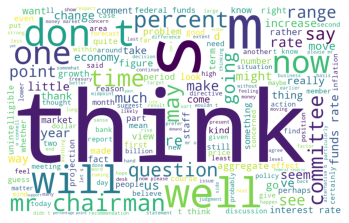

Wordcloud associé à la chair BURNS


In [116]:
df_statement = df_small.groupby('chair_in_charge')['statement'].apply(','.join)
nuage_de_mots(df_statement.iloc[[0]][0])  
print("Wordcloud associé à la chair BURNS")

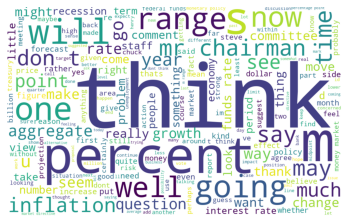

Wordcloud associé à la chair MILLER


In [118]:
nuage_de_mots(df_statement.iloc[[1]][0]) 
print("Wordcloud associé à la chair MILLER")

In [73]:
df_statement.iloc[[0]]['cleaned_statement'][0][0]

'we,are,ready,to,start,our,meeting,this,morning,the,first,item,of,business,as,always,is,to,act,on,the,minutes,of,the,last,meeting,motion,to,approve,seconded,the,motion,has,been,made,and,duly,seconded,no,objections,heard'

In [60]:
df_statement.index

Index(['CHAIRMAN BURNS', 'CHAIRMAN MILLER'], dtype='object', name='chair_in_charge')